In [1]:
from anndata.experimental.read_backed import read_backed
import fsspec, zarr
import scanpy as sc
import os
%load_ext autoreload
%autoreload 2

# First we set up a custom store for tracking how many requests we are making.  This is just a light wrapper around LRUStoreCache that prints when a key has been accessed.

In [2]:
class AccessTrackingStore(zarr.LRUStoreCache):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __getitem__(self, key):
        if key not in self._values_cache:
            print(key)
        return super().__getitem__(key)

In [3]:
mapper = fsspec.get_mapper('https://vitessce-demo-data.storage.googleapis.com/anndata-demos/BALF_VIB-UGent_processed_cleaned.zarr/')
store = AccessTrackingStore(mapper, max_size=2**28)

In [4]:
adata = read_backed(store)

.zmetadata
obs/_index/0obs/_index/2

obs/_index/1
obs/_index/3
obs/_index/4
obs/_index/5
obs/_index/6
obs/_index/7
var/_index/0


In [5]:
adata

AnnDataBacked object with n_obs × n_vars = 275056 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

# Great! We can see that with only a few requests, we can now view all the columns available in this AnnData object.  This is a great start towards understanding what our data is.

# Immediately, we see that this is some sort of COVID-19 dataset.  Maybe we're only interested in those who were COVID-19 positive and died from it.  Let's try to get that subset and observe what happen.

# Note the type of  `obs` - an xarray Dataset.  More info can be found at their homepage: https://docs.xarray.dev/, but this gives AnnData a familiar feeling dataframe API to Pandas while keeping things lazy-loaded.

In [6]:
adata.obs

obs/orig.ident/categories/0
obs/Age/categories/0
obs/Sex/categories/0
obs/Race/categories/0
obs/Ethnicity/categories/0
obs/BMI/categories/0
obs/Method/categories/0
obs/CITE-Seq panel/categories/0
obs/Reference/categories/0
obs/Institute/categories/0
obs/Annotation/categories/0
obs/Smoking/categories/0
obs/28-day outcome/categories/0
obs/Organ System/categories/0
obs/Source/categories/0
obs/Technology/categories/0


<xarray.Dataset>
Dimensions:                                            (obs_names: 275056)
Coordinates:
  * obs_names                                          (obs_names) object 'CO...
Data variables: (12/33)
    orig.ident                                         (obs_names) category ...
    Age                                                (obs_names) category ...
    Sex                                                (obs_names) category ...
    Race                                               (obs_names) category ...
    Ethnicity                                          (obs_names) category ...
    BMI                                                (obs_names) category ...
    ...                                                 ...
    Method                                             (obs_names) category ...
    CITE-Seq panel                                     (obs_names) category ...
    Reference                                          (obs_names) category ...
    Institute                                          (obs_names) category ...
    Creation date                                      (obs_names) float64 dask.array<chunksize=(34382,), meta=np.ndarray>
    Annotation                                         (obs_names) category ...

In [7]:
adata.obs['SARS-CoV-2 PCR']

<xarray.DataArray 'SARS-CoV-2 PCR' (obs_names: 275056)>
dask.array<from-zarr, shape=(275056,), dtype=float64, chunksize=(34382,), chunktype=numpy.ndarray>
Coordinates:
  * obs_names  (obs_names) object 'COV002_AAACCCAAGAGTCTTC-1' ... 'COV037_TTT...

In [8]:
adata.obs['28-day death']

<xarray.DataArray '28-day death' (obs_names: 275056)>
dask.array<from-zarr, shape=(275056,), dtype=float64, chunksize=(34382,), chunktype=numpy.ndarray>
Coordinates:
  * obs_names  (obs_names) object 'COV002_AAACCCAAGAGTCTTC-1' ... 'COV037_TTT...

## These are both xarray DataArrays, with Dask backing data.  Thus we'll need to bring them into memory to create our subset, but this is no problem.  Usually we would hope these are stored as boolean, but floats will work just the same.

In [9]:
has_covid = adata.obs['SARS-CoV-2 PCR'].data.compute().astype('bool')
did_die = adata.obs['28-day death'].data.compute().astype('bool')
subset = adata[has_covid & did_die, :]
subset

obs/SARS-CoV-2 PCR/0obs/SARS-CoV-2 PCR/1

obs/SARS-CoV-2 PCR/2
obs/SARS-CoV-2 PCR/3
obs/SARS-CoV-2 PCR/4
obs/SARS-CoV-2 PCR/5
obs/SARS-CoV-2 PCR/6
obs/SARS-CoV-2 PCR/7
obs/28-day death/0
obs/28-day death/1
obs/28-day death/2
obs/28-day death/3
obs/28-day death/4
obs/28-day death/5
obs/28-day death/6
obs/28-day death/7


AnnDataBacked object with n_obs × n_vars = 57250 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

## That was pretty fast!  Now we're getting somewhere.  Let's look at the cell types present in our dataset.  Note that the backing data of the obs column DataArrray is special - a custom class we use that should feel familiar nonetheless.  We immediately are able to see the available categories here, while only paying for the access to get the categories.  No "real data" has been read in yet.  COVID 19 is known to act (idk?) on CD4 and CD8+ cells, so let's pull those in

In [10]:
subset.obs['Annotation']

<xarray.DataArray 'Annotation' (obs_names: 57250)>
[57250 values with dtype=category]
Coordinates:
  * obs_names  (obs_names) object 'COV013_AAACCCAAGCATCCCG-1' ... 'COV036_TTT...

In [11]:
cell_subset = subset[subset.obs['Annotation'].data[()].isin(['CD4+ T-cell', 'CD8+ T-cell', 'Macrophage', 'Macrophage:Alveolar']), :]
cell_subset

obs/Annotation/codes/0
obs/Annotation/codes/1


AnnDataBacked object with n_obs × n_vars = 16768 × 24740
    obs: 'orig.ident', 'Age', 'Sex', 'Race', 'Ethnicity', 'BMI', 'Pre-existing heart disease', 'Pre-existing lung disease', 'Pre-existing kidney disease', 'Pre-existing diabetes', 'Pre-existing hypertension', 'Pre-existing immunocompromised condition', 'Smoking', 'SARS-CoV-2 PCR', 'SARS-CoV-2 Ab', 'Symptomatic', 'Admitted to hospital', 'Highest level of respiratory support', 'Vasoactive agents required during hospitalization', '28-day death', '28-day outcome', 'Disease classification', 'Organ System', 'Source', 'Days since hospital admission', 'SOFA', 'Technology', 'Method', 'CITE-Seq panel', 'Reference', 'Institute', 'Creation date', 'Annotation'
    var: 'feature_type', 'gene_id'
    obsm: 'X_umap'
    layers: 'X_csc'

# We can now plot some known markers with scanpy.  Unfortunately, this new backed functionality does not work with scanpy.  But we have a convenient to_memory function to help us.  First let's observe something - our `X` matrix is CSR but we are interested in many fewer genes than cells.  Thus it would be better to use a pre-computed layer, `X_csc` which allows us quick access.  We are also only interested in plotting cell types for `obs` so let's exclude everything else.

In [12]:
genes=['CD4', 'CD80', 'ACE2', 'CD40']
obs_keys_to_exclude = ['obs/' + v for v in cell_subset.obs.keys() if v != 'Annotation']
var_keys_to_exclude = ['var/' + v for v in cell_subset.var.keys()]
gene_cell_subset = cell_subset[:, genes].to_memory(exclude=['X'] + obs_keys_to_exclude + var_keys_to_exclude)

var/feature_type/categories/0
var/gene_id/categories/0
obsm/X_umap/0.0
obsm/X_umap/1.0
obsm/X_umap/2.0
obsm/X_umap/3.0
obsm/X_umap/0.1
obsm/X_umap/1.1
obsm/X_umap/2.1
obsm/X_umap/3.1
layers/X_csc/indptr/0
layers/X_csc/data/584
layers/X_csc/data/199
layers/X_csc/data/961
layers/X_csc/data/843
layers/X_csc/indices/292
layers/X_csc/indices/99
layers/X_csc/indices/480
layers/X_csc/indices/421


In [13]:
gene_cell_subset

AnnData object with n_obs × n_vars = 16768 × 4
    obs: 'Annotation'
    obsm: 'X_umap'
    layers: 'X_csc'

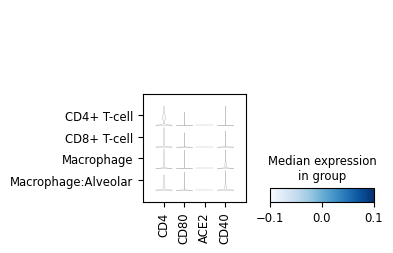

In [14]:
sc.pl.stacked_violin(gene_cell_subset, genes, groupby='Annotation', layer='X_csc')

# Amazing! On a normal internet connection, all of the above steps should take no longer than 30 seconds!  Notice how much data we accessed - only exactly what we needed!  Through smart data access, a clean API, and a few hundred lines of new AnnData code, a whole new access pattern emerges!